## VR PCA (block version)

Initialize: \tilde W_o (d by k), eta (learning rate)

Inner Iterations: m (epoch length), \tilde U, \tilde W_{s-1}, eta

    W_o = \tilde W_{s-1}
    for t in 1,..., m:
        B_{t-1} <- get_rotation_matrix(W_{t-1}, \tilde W_{s-1})
        Sample x from dataset u.a.r.
        W_t_ <- W_{t-1} + eta * (x (x^T W_{t-1} - x^T \tilde W_{s-1}B_{t-1}) + \tilde U B_{t-1})
        W_t <= W_t_ (W_t_^T W_t_)^{-1/2} (orthonormalization)
        
Algo: T (number of epochs), \tilde W_o, eta

    for s in 1,...,T:
        \tilde U <- 1/n sum_{i=1}^n x_i (x_i^T \tilde W_{s-1})
        \tilde W_s <- inner_iterations(m, \tilde U, \tilde W_{s-1}, eta)

In [1]:
from vr-pca import VRPCA, get_random

import numpy as np
import scipy as sp
import random

In [2]:
class VRPCA(object):
    def __init__(self, init_weights, train_data, ground_truth, learning_rate, m, T):
        """
        init_weights: k by d
        ground_truth: rows of top k eigenvectors of training data, k by d
        train_data: rows of data points, n by d
        """
        self.X = train_data
        self.W_init = init_weights.transpose()
        #self.W = None
        self.gt = ground_truth.transpose()
        self._set_eta(learning_rate)
        self.m = m
        self.T = T
    
    def _train(self):
        self._reset_train_logs()
        W_tilde = self.W_init
        self._register_eval_metrics(W_tilde)
        print(f"The initial loss is {self._train_log[-1]}")
        for t in range(self.T):
            U_tilde = 1.0/len(self.X) * np.matmul(np.matmul(self.X.T, self.X), W_tilde)
            W_tilde = self._train_inner(U_tilde, W_tilde)
            self._register_eval_metrics(W_tilde)
            print(f"The loss at the {t+1}-th epoch is {self._train_log[-1]}")
    
    
    def _train_inner(self, U_out, W_out):
        
        W_ = W_out.copy()
        for t in range(self.m):
            B = get_rotation_matrix(W_, W_out)
#             if t == 0 or t == 1:
#                 Diff = W - np.matmul(W_out, B)
            x = self._get_sample_from_train()
            W = svrg_power_iteration_update(x, W_, W_out, U_out, B, self.eta)
            W_ = orthonormalize(W)
            #self._register_eval_metrics(W_)
        return W
            
            
    def _set_eta(self, lr):
        self.eta = lr
        
            
    def _get_sample_from_train(self):
        # random indx
        ridx = random.randint(0, len(self.X)-1)
        return self.X[ridx]
    
    
    def _reset_train_logs(self):
        self._train_log  = []
        
    
    def _register_eval_metrics(self, weights):
        """
        register the evaluation metrics to train log during training 
        """
        loss = eval_with_groundtruth(self.gt.transpose(), weights.transpose())
        self._train_log.append(loss)


def get_rotation_matrix(W_1, W_2):
    """
    W_1/W_2: d by k
    Find the optimal rotation matrix B of W_2
    so that it's closest to W_1 in Frobenius norm
    """
    u, _, vh = np.linalg.svd(np.matmul(W_1.T, W_2))
    return np.matmul(u, vh).transpose()


def svrg_power_iteration_update(x, W, W_out, U_out, B, learning_rate):
    """
    Perform one iteration of SVRG update on W
    """
    A_tilde = np.matmul(np.expand_dims(x, axis=1), np.expand_dims(x, axis=0)) # check A_tilde
    Dif = W - np.matmul(W_out, B)
    #print(A_tilde.shape)
    #print(Dif.shape)
    Imp = np.matmul(A_tilde, Dif) + np.matmul(U_out, B)
    W_ = W + learning_rate * Imp 
    return orthonormalize(W_)


def orthonormalize(W):
    W_sqrt = sp.linalg.sqrtm(np.matmul(W.T, W))
    #print(sp.linalg.sqrtm(np.matmul(W.T, W)))
    W_sqrt_inv = np.linalg.inv(W_sqrt) 
    return np.matmul(W, W_sqrt_inv) 


def eval_with_groundtruth(groundtruth, weights):
    """
    Input: 
        groundtruth, rows of top k eigenvectors, k by d
        weights, np array, shape k by d (row-orthonormal)
    Return:
        tr(U(I-P)): U-projection matrix of eigenvectors, 
                    P: projection matrix of weights
    """
    #eigenvecs = get_eigenvecs(groundtruth)
    eigenvecs = groundtruth.copy()
    U = np.matmul(eigenvecs.T, eigenvecs)
    P = np.matmul(weights.T, weights)
    I = np.eye(weights.shape[1])
    
    return np.trace(np.matmul(U, I-P))

def get_default_learning_rate(X):
    rbar = np.linalg.norm(X, ord='fro')
    return 1/rbar * (len(X) ** 0.5)
        
        

In [3]:
# data generators: data should be centered and dispersed around the subspace spanned by gt

def get_train_data(n_train, groundtruth=None):
    """
    gt: d-dimensional vec (non-increasing entries): 
    nonzero at coordinates corresponding to eigenvectors, and the value corresponds eigenvalue
    example: [1,1,0,0,0]
    return: np array train data
    """
    if not groundtruth:
        print("The data generator without groundtruth is not implemented!")
        return
    else:
        train_data = None
        d = len(groundtruth)
        for _ in range(n_train):
            x = np.zeros([1, d])
            for i in range(d):
                if groundtruth[i] > 0 :
                    x[:, i] = np.random.normal(0, groundtruth[i]**0.5)
                else:
                    break
            if train_data is None:
                train_data = x
            else:
                train_data = np.concatenate((train_data, x), axis=0)  
            #print(train_data.shape)
    return train_data


def get_eigenvecs(groundtruth):
    """
    Input: groundtruth in the form of list [1,1,0]
    Return: np array, eigenvecs: k by d
    """
    d = len(groundtruth)
    eigenvecs = None
    for dim in range(d):
        if groundtruth[dim] > 0:
            eigenvec = np.zeros([1, d])
            eigenvec[:, dim] = 1.0
            if eigenvecs is None:
                eigenvecs = eigenvec
            else:
                eigenvecs = np.concatenate((eigenvecs, eigenvec), axis=0)
        else:
            break
    return eigenvecs

In [4]:
import tensorflow as tf

## initializers
def get_random_orthogonal_initializer(k, d, gain=1, seed=None):
    tf.reset_default_graph()
    init_fn = tf.orthogonal_initializer(gain, seed, dtype=tf.float64)
    init_weights = tf.get_variable('init_weights', initializer=init_fn, shape=[k, d])
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())   
        _init_weights = sess.run([init_weights])[0]
    return _init_weights

/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
k=2
d=100
gt = [0] * d
for i in range(k):
    gt[i] = (k - i)**1
_init_weights = get_random_orthogonal_initializer(k, d)
n_train = 5000
eigenvecs = get_eigenvecs(gt)
train_data = get_train_data(n_train, groundtruth=gt)

In [ ]:
_init_weights

In [ ]:
m = n_train
T = 4
lr = 0.01

algo = VRPCA(_init_weights, train_data, eigenvecs, lr, m, T)

In [ ]:
algo._train()

In [17]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
%matplotlib inline

In [ ]:
import math

iterations = range(T * m + 1)
#log_iterations = [math.log(t+1) for t in iterations]
log_error = [math.log(y) if y > 0 else 0 for y in algo._train_log]

In [ ]:
#plt.plot(iterations, log_error)
plt.plot(iterations, log_error)

In [ ]:
algo._train_log[:20]

In [7]:
from numpy.random import RandomState
from sklearn.datasets import fetch_olivetti_faces

rng = RandomState(0)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)

Dataset consists of 400 faces


In [8]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.8, svd_solver='full')
pca.fit(faces_centered)
pca.n_components_

37

In [11]:
##
k = 37
d = 4096
_init_weights = get_random_orthogonal_initializer(k, d)

n_train = len(faces_centered)
T = 5
#lr = get_default_learning_rate(faces_centered)
lr = 0.01
#lr = 0.0001
#lr = (0.001, 10)
algo = VRPCA(_init_weights, faces_centered, pca.components_, lr, n_train, T)

In [12]:
algo._train()

The initial loss is 36.67178005243223
The loss at the 1-th epoch is (22.18246366992512+5.806116807207437e-11j)
The loss at the 2-th epoch is (11.867549529359964+3.589131690158106e-10j)
The loss at the 3-th epoch is (6.1107071765143175-4.370119975188168e-10j)
The loss at the 4-th epoch is (3.6274984776615096-4.337703163382074e-10j)
The loss at the 5-th epoch is (2.548405372491474-6.351672089533364e-10j)


In [20]:
import math

eps = 1e-6
iterations = range(T + 1)
#log_iterations = [math.log(t+1) for t in iterations]
log_error = [math.log(y) if y > 0 else 0 for y in algo._train_log]

/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys


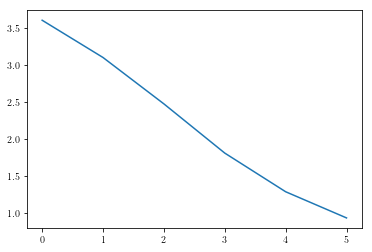

In [23]:
plt.plot(iterations, log_error)
#plt.plot(iterations, algo._train_log, '-o')

## MNIST

In [5]:
from mnist import MNIST
from sklearn.decomposition import PCA
import numpy as np

mndata = MNIST('python-mnist/data')
images, labels = mndata.load_training()

images_array = np.array([np.array(data_pt) for data_pt in images[:5000]])
n_samples, n_features = images_array.shape
images_centered = images_array - images_array.mean(axis=0)
images_centered -= images_centered.mean(axis=1).reshape(n_samples, -1)

In [6]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.8, svd_solver='full')

In [7]:
pca.fit(images_centered)

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [8]:
##
k = 44
d = 784
_init_weights = get_random_orthogonal_initializer(k, d)

_init_weights = get_random_orthogonal_initializer(k, d)

n_train = len(images_centered)
T = 5
#lr = get_default_learning_rate(faces_centered)
lr = 0.01
#lr = 0.0001
#lr = (0.001, 10)
algo = VRPCA(_init_weights, images_centered, pca.components_, lr, n_train, T)

In [9]:
algo._train()

The initial loss is 41.442170451799534
The loss at the 1-th epoch is 10.526272235354012
The loss at the 2-th epoch is (6.426798804695839-0.23020677856926336j)
The loss at the 3-th epoch is (4.515751648735364+0.22419113652120082j)
The loss at the 4-th epoch is (3.3245955482582747+0.12286200866095186j)
The loss at the 5-th epoch is (2.64987992462832+0.1034978966115341j)
